<a href="https://colab.research.google.com/github/rahiakela/small-language-models-fine-tuning/blob/main/domain-specific-small-language-models/04-model-quantization/02_gpt_2_sm_quantization_with_llm_int8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantization of the GPT-2 Small Model with LLM.int8()


The code in this notebook is to introduce readers to the quantization of a decoder-only language model, [GPT-2 Small](https://huggingface.co/openai-community/gpt2) using [LLM.int8()](https://arxiv.org/abs/2208.07339). It requires hardware acceleration (GPU).

**LLM.int8()** does matrix multiplication computation in three steps:

* It extracts columns from the input hidden states containing outlier features using a custom threshold.
* Then it performs the matrix multiplication of the outliers in fp16 and the non-outliers in int8 with vector-wise quantization.
* Finally, it dequantizes the non-outlier results (int8 to fp16) and add them to the outlier results to get the full result in fp16.

Install the missing requirements (HF's Accelerate and Bitsandbytes).

In [ ]:
!pip install accelerate bitsandbytes

Import the required packages and classes.

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

Download the GPT-2 model and associated tokenizer from the HF's Hub and load it to GPU. Finally print the size (in bytes) of the model in memory.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_id = 'openai-community/gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_id)

print(f"Model size: {model.get_memory_footprint():,} bytes")

## LLM.int8() quantization

**You can load a quantized GPT-2 Small model using LLM.int8() strategy by just simply setting a parameter called load_in_8_bit to True.**

Download the GPT-2 model in 8-bit from the HF's Hub and load it to GPU. Finally print the size (in bytes) of the model in memory.

In [4]:
model_int8 = AutoModelForCausalLM.from_pretrained(model_id, device_map='auto', load_in_8bit=True,)

print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

Model size: 176,527,896 bytes


In [6]:
print(f"Model size: {int(model_int8.get_memory_footprint()/1024/1024)} GB")

Model size: 168 GB


Get the original model's and 8-bit model's weights and prepare them for visualization in a histogram chart.

In [7]:
import numpy as np

weights = [param.data.clone() for param in model.parameters()]
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_int8 = [param.data.clone() for param in model_int8.parameters()]
weights_int8 = np.concatenate([t.cpu().numpy().flatten() for t in weights_int8])

## Visualize weights distribution

Using the matplotlib library, plot the distribution of the weights for the original model and the 8-bit version both on the same histogram chart.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

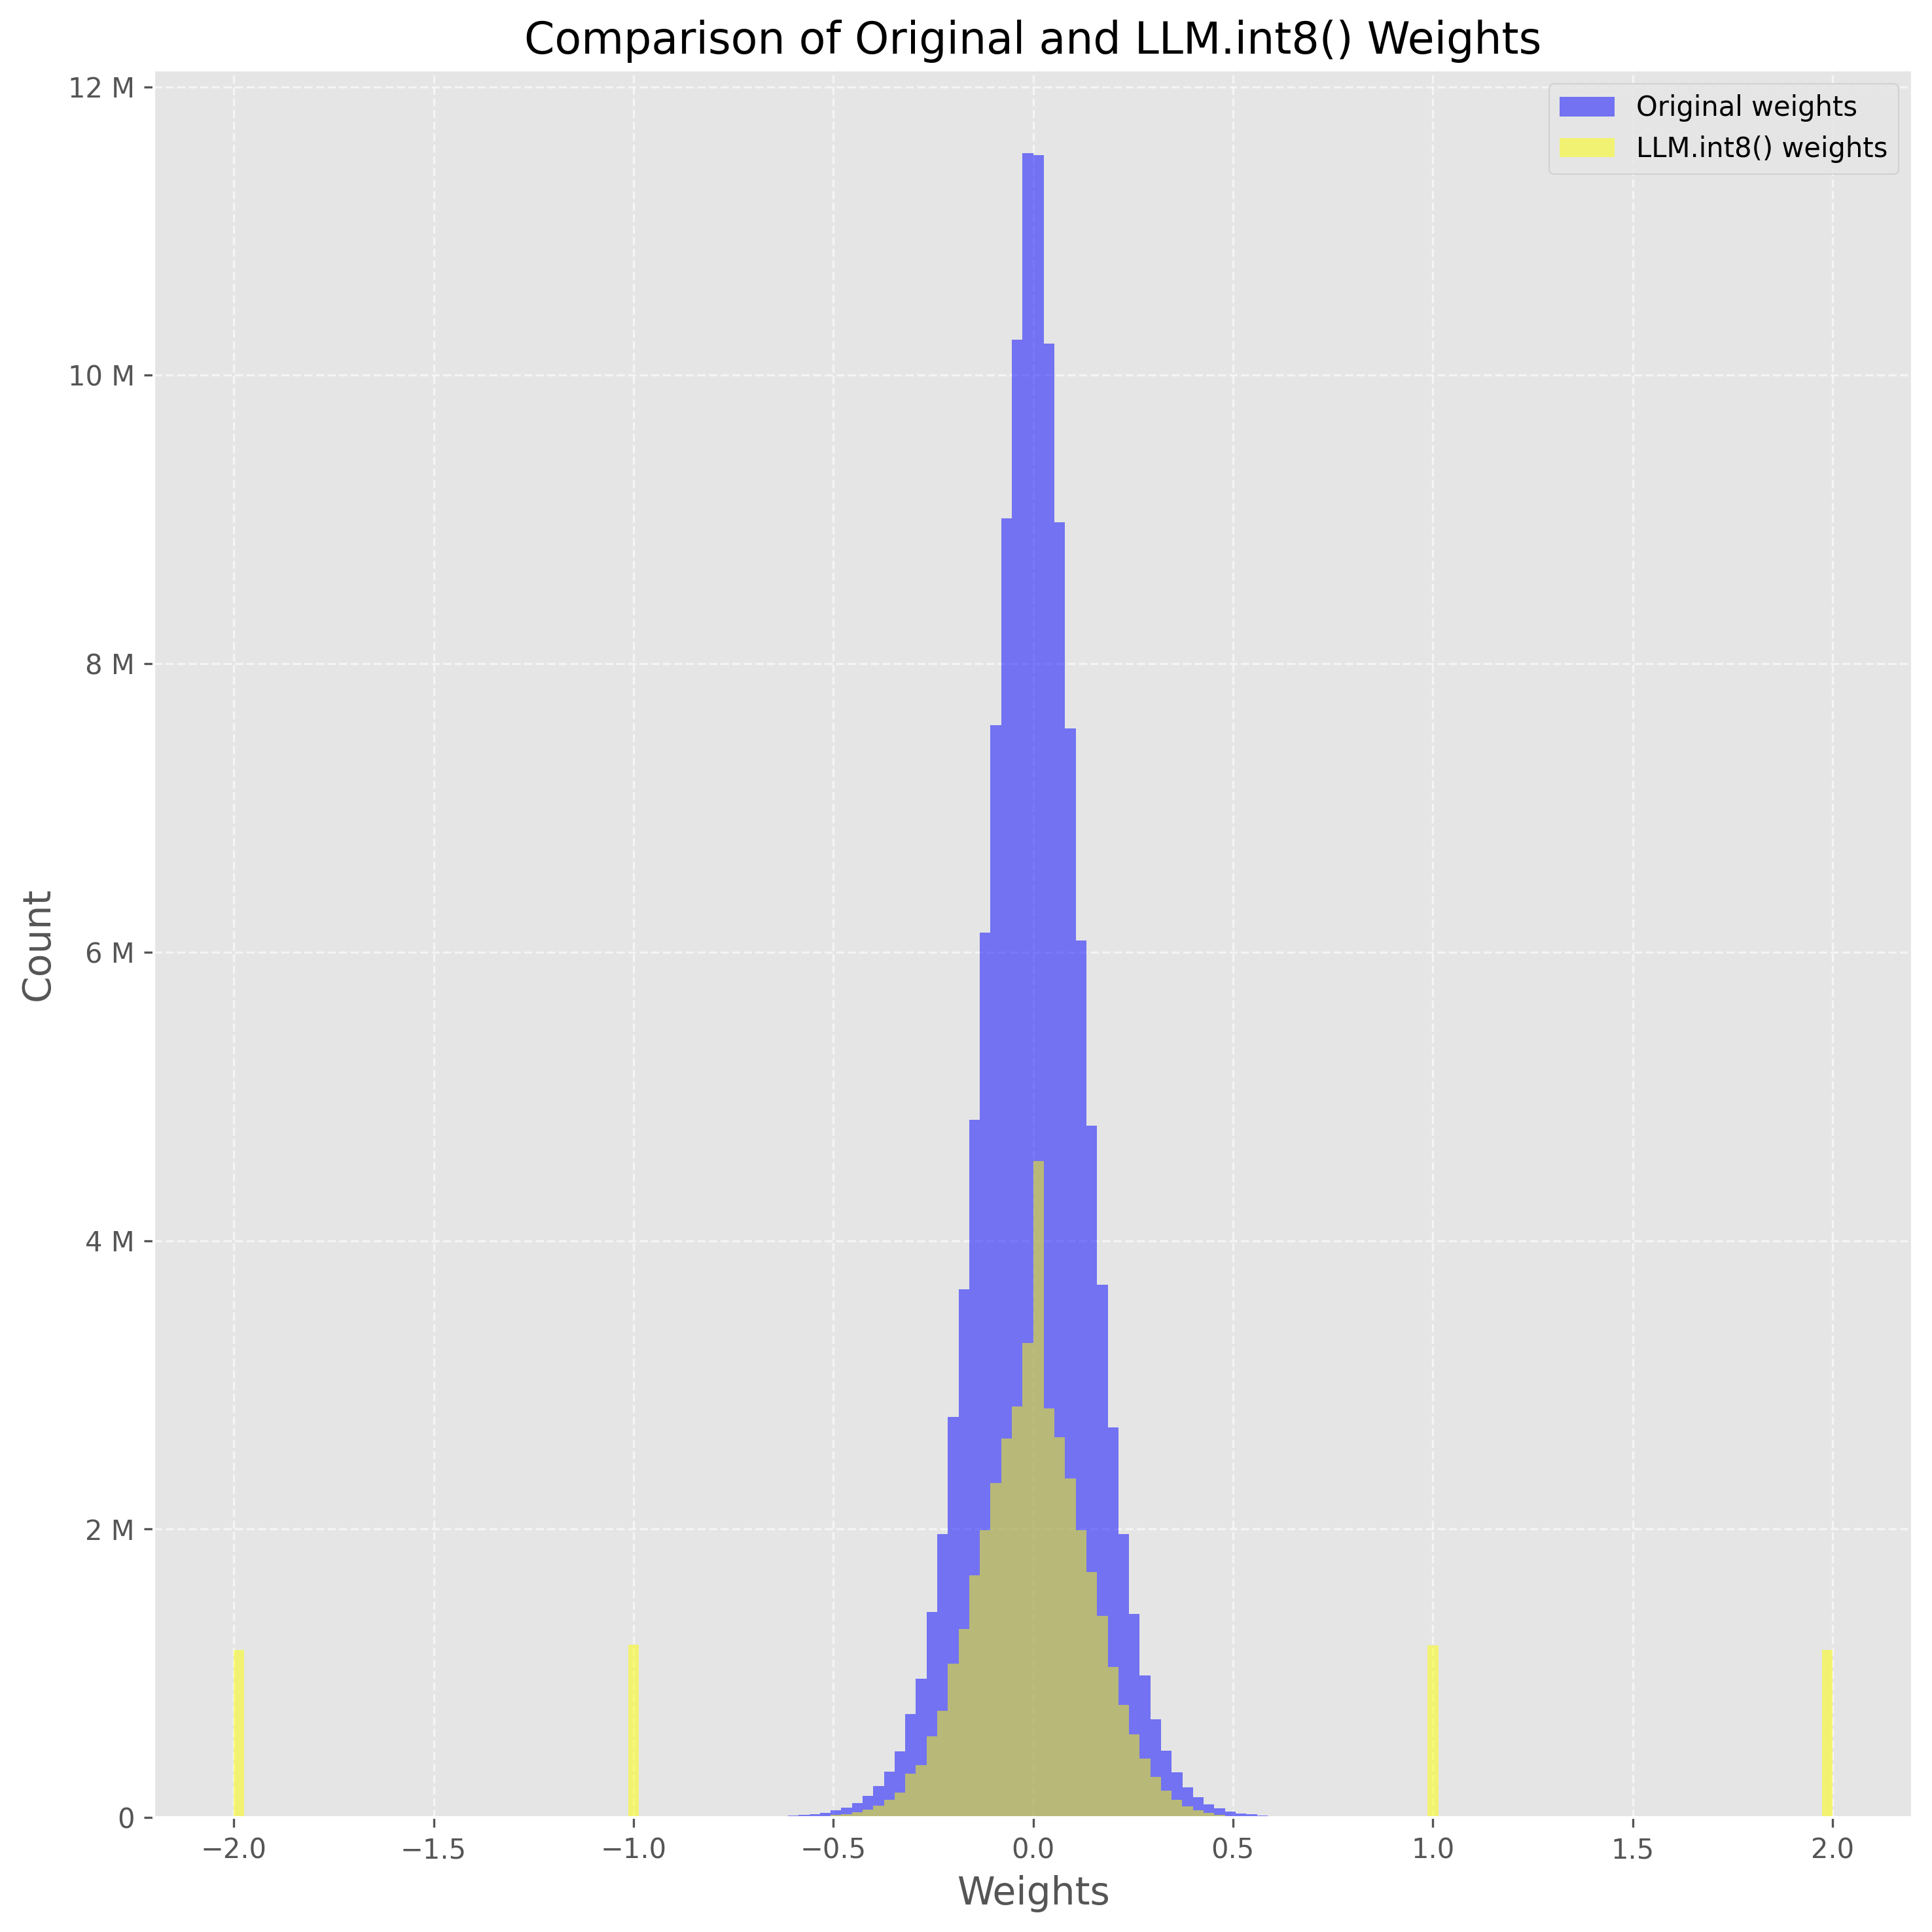

In [9]:
# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(1, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs.hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs.hist(weights_int8, bins=150, alpha=0.5, label='LLM.int8() weights', color='yellow', range=(-2, 2))

# Add grid
axs.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs.legend()

# Add title and labels
axs.set_title('Comparison of Original and LLM.int8() Weights', fontsize=16)

axs.set_xlabel('Weights', fontsize=14)
axs.set_ylabel('Count', fontsize=14)
axs.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

## Inference

Define a function to generate text, whatever the model (original or quantized).

In [10]:
def generate_text(model, input_text, max_length=100):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

Use the text generation function defined in the previous code cell to generate text with both model version (the original and the 8-bit quantizated one).

In [11]:
prompt = 'My favourite school subject is'
original_text = generate_text(model, prompt)
text_int8 = generate_text(model_int8, prompt)

print(f"Original model:\n{original_text}")
print(f"LLM.int8() model:\n{text_int8}")

Original model:
My favourite school subject is football. The game is always on.

"But football is a game. So I think you've become a great sport, because it's a big sport and it's a real sport. Football is an all-round game.

"You've got to play well, you've got to take responsibility for your footballs, you've got to keep your feet on the ground.

"So I'd say to me, I was thinking: '
LLM.int8() model:
My favourite school subject is the science of nutrition. While there are many good sources of nutrition in the diet, some of these sources are not widely shared among consumers. The scientific and moral arguments and social studies that provide evidence for dieting in childhood are often ignored.

The fact that there are no studies to establish the dietary guidelines that are used to determine what type of food is safe is not surprising. In fact, while the American Academy of Pediatrics has a great number of "facts" that


## Calculate perplexity

Define a function to calculate the perplexity score.

In [12]:
def calculate_perplexity(model, text, device):
    encodings = tokenizer(text, return_tensors='pt').to(device)

    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    neg_log_likelihood = outputs.loss

    perplexity = torch.exp(neg_log_likelihood)

    return perplexity

Calculate the perplexity score for both versions of the model, using the text results previously generated by both.

In [13]:
perplexity = calculate_perplexity(model, original_text, device)
perplexity_int8 = calculate_perplexity(model_int8, text_int8, device)
print(f"Original Perplexity:   {perplexity.item():.2f}")
print(f"LLM.int8() perplexity: {perplexity_int8.item():.2f}")

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Original Perplexity:   9.56
LLM.int8() perplexity: 14.46
